In [2]:
import math
from scipy import stats
from statsmodels.stats.proportion \
    import proportion_confint, proportions_ztest

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ppf(dist, **kwargs):
    x = np.arange(0, 1, 0.001)
    fig, ax = plt.subplots()
    ax.plot(x, dist.ppf(x, **kwargs))
    
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    # ax.grid(True, which='both')
    return fig, ax

def plot_cdf(dist, **kwargs):
    x = np.arange(-4, 4, 0.001)
    fig, ax = plt.subplots()
    ax.plot(x, dist.cdf(x, **kwargs))
    ax.plot(x, dist.pdf(x, **kwargs))
    
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    # ax.grid(True, which='both')
    return fig, ax

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple

TtestResult = namedtuple('TtestResult', ['statistic', 'pvalue', 'df'])

def ttest_1samp(mean, std, n, popmean=0, alternative='two-sided'):

    SE = std / math.sqrt(n) # standard error
    T = (mean - popmean) / SE # T statistic
    
    match alternative:
        case 'less':
            pval = stats.t.cdf(T, df=n-1)
        case 'two-sided':
            pval = stats.t.cdf(T, df=n-1) * 2
        case 'greater':
            pval = 1 - stats.t.cdf(T, df=n-1)

    return TtestResult(statistic=T, pvalue=pval, df=n-1)

def plines(plt, x, f, colors=None, linestyles='dotted'):
    plt.vlines(x, 0, f(x), linestyles=linestyles, colors=colors)
    plt.hlines(f(x), 0, x, linestyles=linestyles, colors=colors)

def area(plt, xmin, xmax, f, color):
    section = np.arange(xmin, xmax, 0.001)
    plt.fill_between(section, f(section), color=color, alpha=0.5)

class TtestPlot:

    def __init__(self, result, alpha=0.05, alternative='two-sided') -> None:
        self.result = result
        self.alpha=alpha
        self.alternative=alternative
    
    def plot_ppf(self, plt, loc=0, scale=1, alternative='two-sided'):
        ppf = lambda x: stats.t.ppf(x, df=self.result.df, loc=loc, scale=scale)

        x = np.arange(0, 1, 0.001)
        fig, ax = plt.subplots()
        ax.plot(x, ppf(x))
        
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        # ax.grid(True, which='both')

        ppf = lambda x: stats.t.ppf(x, df=self.result.df, loc=loc, scale=scale)

        ptail = {
            'less':         (self.alpha,        1,                  'tab:red'),
            'two-sided':    (self.alpha / 2,    1 - self.alpha / 2, 'tab:blue'),
            'greater':      (0,                 1 - self.alpha,     'tab:green'),
        }

        for alt, _ptail in ptail.items():
            if alt == alternative or alt in alternative:
                xmin, xmax = _ptail[0], _ptail[1]
                ymin = max(loc - 3.5 * scale, ppf(_ptail[0]))
                ymax = min(ppf(_ptail[1]), loc + 3.5 * scale)
                section = np.arange(xmin, xmax, 0.001)
                plt.fill_between(section, ymin, ymax, color=_ptail[2], alpha=0.5)

                match alt:
                    case 'less':
                        plt.hlines(
                            ppf(ptail['less'][0]),
                            xmin=0,
                            xmax=1,
                            colors='tab:red',
                            linestyles='dotted'
                            )
                    case 'two-sided':
                        plt.hlines(
                            ppf([ptail['two-sided'][0], ptail['two-sided'][1]]),
                            xmin=0,
                            xmax=[1 - self.alpha / 2, 1 - self.alpha / 2],
                            colors='tab:blue',
                            linestyles='dotted'
                            )
                    case 'greater':
                        plt.hlines(
                            ppf(ptail['greater'][1]),
                            xmin=0,
                            xmax=1 - self.alpha,
                            colors='tab:green',
                            linestyles='dotted'
                            )
                    case '_':
                        plt.hlines(
                            ppf([ptail['greater'][1], ptail['two-sided'][0], ptail['two-sided'][1], ptail['less'][0]]),
                            xmin=0,
                            xmax=[1 - self.alpha, 1 - self.alpha / 2, 1 - self.alpha / 2, 1],
                            colors=['tab:green', 'tab:blue', 'tab:blue', 'tab:red'],
                            linestyles='dotted'
                            )

        return fig, ax
    
    def plot_cdf(self, plt, loc=0, scale=1, alternative='two-sided'):
        # loc, scale = 0, 1
        pdf = lambda x: stats.t.pdf(x, df=self.result.df, loc=loc, scale=scale)
        cdf = lambda x: stats.t.cdf(x, df=self.result.df, loc=loc, scale=scale)

        xmin, xmax = loc - 4 * scale, loc + 4 * scale
        x = np.linspace(xmin, xmax, num=1000)
        fig, ax = plt.subplots()
        ax.plot(x, pdf(x))
        ax.plot(x, cdf(x))
        
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        # ax.grid(True, which='both')

        _x = self.result.statistic * scale

        match alternative:
            case 'less':
                area(plt, xmin, loc + _x, pdf, color='tab:blue')
                plines(plt, [loc + _x], cdf, colors='tab:orange')
            case 'two-sided':
                area(plt, xmin, loc + _x, pdf, color='tab:blue')
                area(plt, loc - _x, xmax, pdf, color='tab:blue')
                plines(plt, [loc + _x, loc - _x], cdf, colors='tab:orange')
            case 'greater':
                area(plt, xmin, loc - _x, pdf, color='tab:blue')
                plines(plt, [loc - _x], cdf, colors='tab:orange')
        
        return fig, ax

In [5]:
result = ttest_1samp(mean=-0.545, std=8.887, n=200)
plot = TtestPlot(result)
result

TtestResult(statistic=-0.8672739861520613, pvalue=0.3868364741993471, df=199)

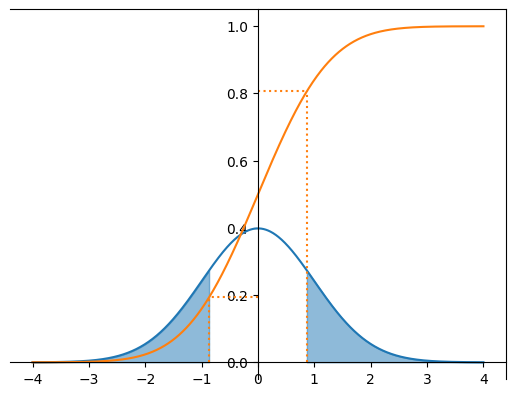

In [9]:
fig, ax = plot.plot_cdf(plt, alternative='two-sided')

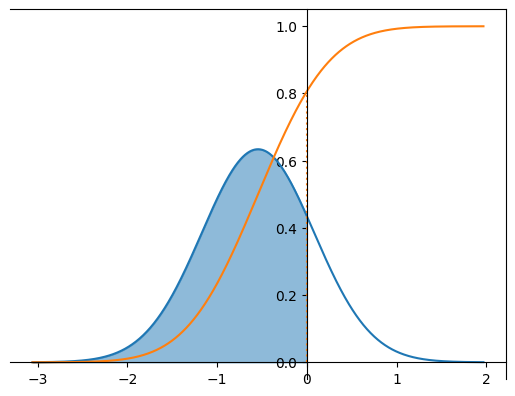

In [11]:
fig, ax = plot.plot_cdf(plt, loc=-0.545, scale=8.887/math.sqrt(200), alternative='greater')

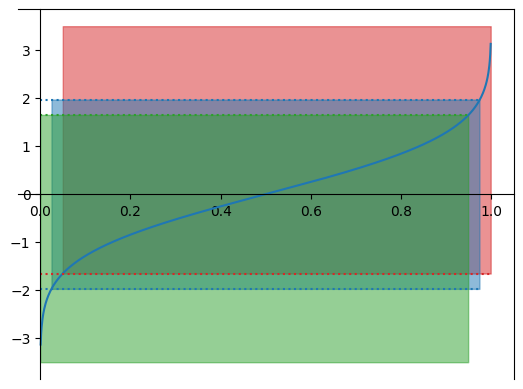

In [15]:
fig, ax = plot.plot_ppf(plt, alternative=['less', 'two-sided', 'greater'])

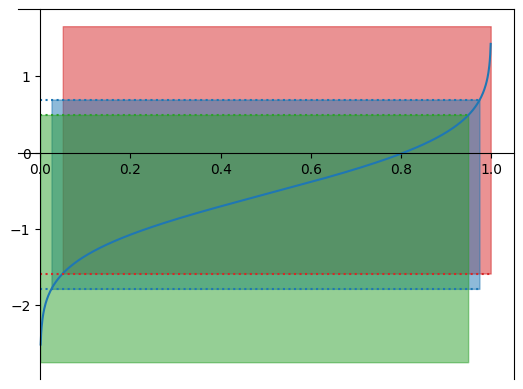

In [16]:
fig, ax = plot.plot_ppf(plt, loc=-0.545, scale=8.887/math.sqrt(200), alternative=['less', 'two-sided', 'greater'])

In [21]:
stats.t.interval(0.95, loc=-0.545, scale=8.887/math.sqrt(200), df=200-1)

(-1.784188922735067, 0.6941889227350669)